In [ ]:
from sklearn.preprocessing import LabelEncoder

# 전처리

In [162]:
class regin(object):
    def __init__(self):
        self.maxscale = lambda x: x / x.max()
        
    def read_data(self, fileloc, train_switch=True):
        self.train_switch = train_switch
        self.fileloc = fileloc
        if train_switch:
            column1 = ['buyinhour', 'plat_A', 'plat_B', 'plat_C', 'plat_D', 'total_session', 'comic_hash', 'privacy_1', 'privacy_2', 'privacy_3']
        else:
            column1 = ['plat_A', 'plat_B', 'plat_C', 'plat_D', 'total_session', 'comic_hash', 'privacy_1', 'privacy_2', 'privacy_3']
        column2 = ['comic' + str(x+1) for x in range(100)] 
        column3 = ['comic_tag1', 'coin_needed', 'end']
        column4 = ['schedule' + str(x+1) for x in range(123-114+1)]
        column5 = ['genre' + str(x+1) for x in range(141-124+1)] 
        column6 = ['last_episode', 'book', 'comic_start', 'total_episode']
        column7 = ['comic_tag' + str(x+2) for x in range(151-146+1)] 
        column8 = ['user_tendency' + str(x+1) for x in range(167-152+1)]
        self.columns = column1 + column2 + column3 + column4 + column5 + column6 + column7 + column8
        data = pd.read_csv(fileloc, sep='\t', header=None, names=self.columns)
        # user tendency는 어떻게 처리할 줄 몰라서 빼기로함
        data = data.drop(column8, 1)
        # privacy2 하고 3도 일단 보류
        data = data.drop(['privacy_2', 'privacy_3'], 1)
        
        self.labelen = LabelEncoder()
        #comic_hash
        comic_hash = data['comic_hash'].unique()
        self.comic_labelen = self.labelen.fit(comic_hash)
        data['comic_hash_cat'] = self.comic_labelen.transform(data.loc[:, 'comic_hash'].values)

        #privacy_1
        privacy_1 = data['privacy_1'].unique() 
        self.privacy_1_labelen = self.labelen.fit(privacy_1)
        data['privacy_cat'] = self.privacy_1_labelen.transform(data.loc[:, 'privacy_1'].values)
        
        #privacy_comic_table
        self.privacy_comic = data.groupby(['privacy_cat'])[column2].max() # test할 때는 이 테이블 갱신해줘야함
        self.privacy_comic_scaled = self.maxscale(self.privacy_comic)
        self.purchasing_power = self.privacy_comic_scaled.mean(axis=1)
        
        bins = [-1, 0.2, 0.5, 0.6, 0.8, 1] # 향후 이것도 업데이트하는 방식으로 구현해볼만 할듯
        labels = [0, 1, 2, 3, 4]
        cats = pd.cut(purchasing_power, bins, labels=labels)
        
        data = pd.merge(data, pd.DataFrame(cats, columns=['purchasing_power']).reset_index(), on='privacy_cat', how='outer', sort=False)
        #df 칼럼 조정
        c = data.columns.tolist()
        lst = ['comic_hash_cat', 'privacy_cat', 'comic_hash', 'privacy_1'] + column2
        for i in lst:
            c.remove(i)
        c = c + lst
        idx = c.index('purchasing_power')
        
        self.data = data.loc[:, c]
        if train_switch:
            self.y = self.data['buyinhour']
            self.X = self.data.iloc[:,range(1, idx+1)]
        else:
            self.X = self.data.iloc[:,range(0, idx+1)]
            
    def return_data(self):
        if self.train_switch:
            return self.X, self.y, self.data
        else:
            return self.X, self.data
    

In [163]:
regin = regin()

In [164]:
regin.read_data('./data/lezhin_dataset_v2_training.tsv')
train_X, train_y, train_data = regin.return_data()

In [165]:
regin.read_data('./data/lezhin_dataset_v2_test_without_label.tsv', train_switch=False)
test_X, test_data = regin.return_data()

In [169]:
train_X.head()

,plat_A,plat_B,plat_C,plat_D,total_session,comic_tag1,coin_needed,end,schedule1,schedule2,...,book,comic_start,total_episode,comic_tag2,comic_tag3,comic_tag4,comic_tag5,comic_tag6,comic_tag7,purchasing_power
0,0,0,0,1,1,1,4,0,0,0,...,1,19,1,0,0,0,0,0,0,1
1,0,0,0,1,1,0,3,0,0,1,...,0,17,3,0,0,0,0,0,0,1
2,0,0,0,1,1,1,3,0,0,1,...,0,14,6,0,0,0,0,0,0,1
3,0,0,0,1,1,1,3,0,0,0,...,0,14,4,0,0,0,0,0,0,1
4,0,0,0,1,104,1,3,1,0,0,...,0,5,10,0,0,0,0,1,0,1


In [167]:
test_X.head()

,plat_A,plat_B,plat_C,plat_D,total_session,comic_tag1,coin_needed,end,schedule1,schedule2,...,book,comic_start,total_episode,comic_tag2,comic_tag3,comic_tag4,comic_tag5,comic_tag6,comic_tag7,purchasing_power
0,0,1,0,0,960,0,3,0,1,0,...,0,10,9,0,0,0,0,0,0,3
1,0,0,0,1,62,1,3,0,0,0,...,0,13,6,0,0,0,0,0,0,3
2,0,0,0,1,9,1,3,0,0,1,...,0,18,1,0,0,0,0,0,0,3
3,0,0,0,1,25,1,3,0,0,0,...,0,16,4,0,0,0,0,0,0,3
4,0,1,0,0,128,1,0,1,0,0,...,0,10,3,0,0,0,1,0,0,3


In [7]:
column1 = ['buyinhour', #1 1시간 이내에 구매여부
           'plat_A', 'plat_B', 'plat_C', 'plat_D', #2~5 사용플랫폼 A~D
           'total_session', #6 목록 진입시점 방문 총 세션수
           'comic_hash', #7 작품을 나타내는 해쉬
           'privacy_1', 'privacy_2', 'privacy_3', #8~10 개인정보
          ] 
column2 = ['comic' + str(x+1) for x in range(100)] 
#11~110 주요 작품 구매여부
column3 = ['comic_tag1', #111 작품태그
           'coin_needed', #112 구매시 필요코인
           'end', #113 완결 여부
          ]
column4 = ['schedule' + str(x+1) for x in range(123-114+1)]
#114~123 스케쥴정보
column5 = ['genre' + str(x+1) for x in range(141-124+1)] 
#124~141 장르정보
column6 = ['last_episode', #142 마지막 에피소드 발행 시점
           'book', #143 단행본여부
           'comic_start', #144 작품 발행 시점
           'total_episode', #145 총 발행 에피소드
          ]

column7 = ['comic_tag' + str(x+2) for x in range(151-146+1)] 
#146~151 작품태그
column8 = ['user_tendency' + str(x+1) for x in range(167-152+1)]
#152~167 유저성향 정보, 과거 구매시 기록

columns = column1 + column2 + column3 + column4 + column5 + column6 + column7 + column8

raw_data = pd.read_csv('./data/lezhin_dataset_v2_training.tsv', sep='\t', header=None, names=columns )

In [26]:
data = raw_data.copy()

In [27]:
# user tendency는 어떻게 처리할 줄 몰라서 빼기로함
data = data.drop(column8, 1)
# privacy2 하고 3도 일단 보류
data = data.drop(['privacy_2', 'privacy_3'], 1)

In [28]:
from sklearn.preprocessing import LabelEncoder
labelen = LabelEncoder()

In [29]:
#comic_hash
comic_hash = data['comic_hash'].unique()
comic_labelen = labelen.fit(comic_hash)
data['comic_hash_cat'] = comic_labelen.transform(data.loc[:, 'comic_hash'].values)

#privacy_1
privacy_1 = data['privacy_1'].unique() #일단 2와 3은 보류
privacy_1_labelen = labelen.fit(privacy_1)
data['privacy_cat'] = privacy_1_labelen.transform(data.loc[:, 'privacy_1'].values)

In [129]:
privacy_comic_table = data.groupby(['privacy_cat'])[column2].max() # test할 때는 이 테이블 갱신해줘야함

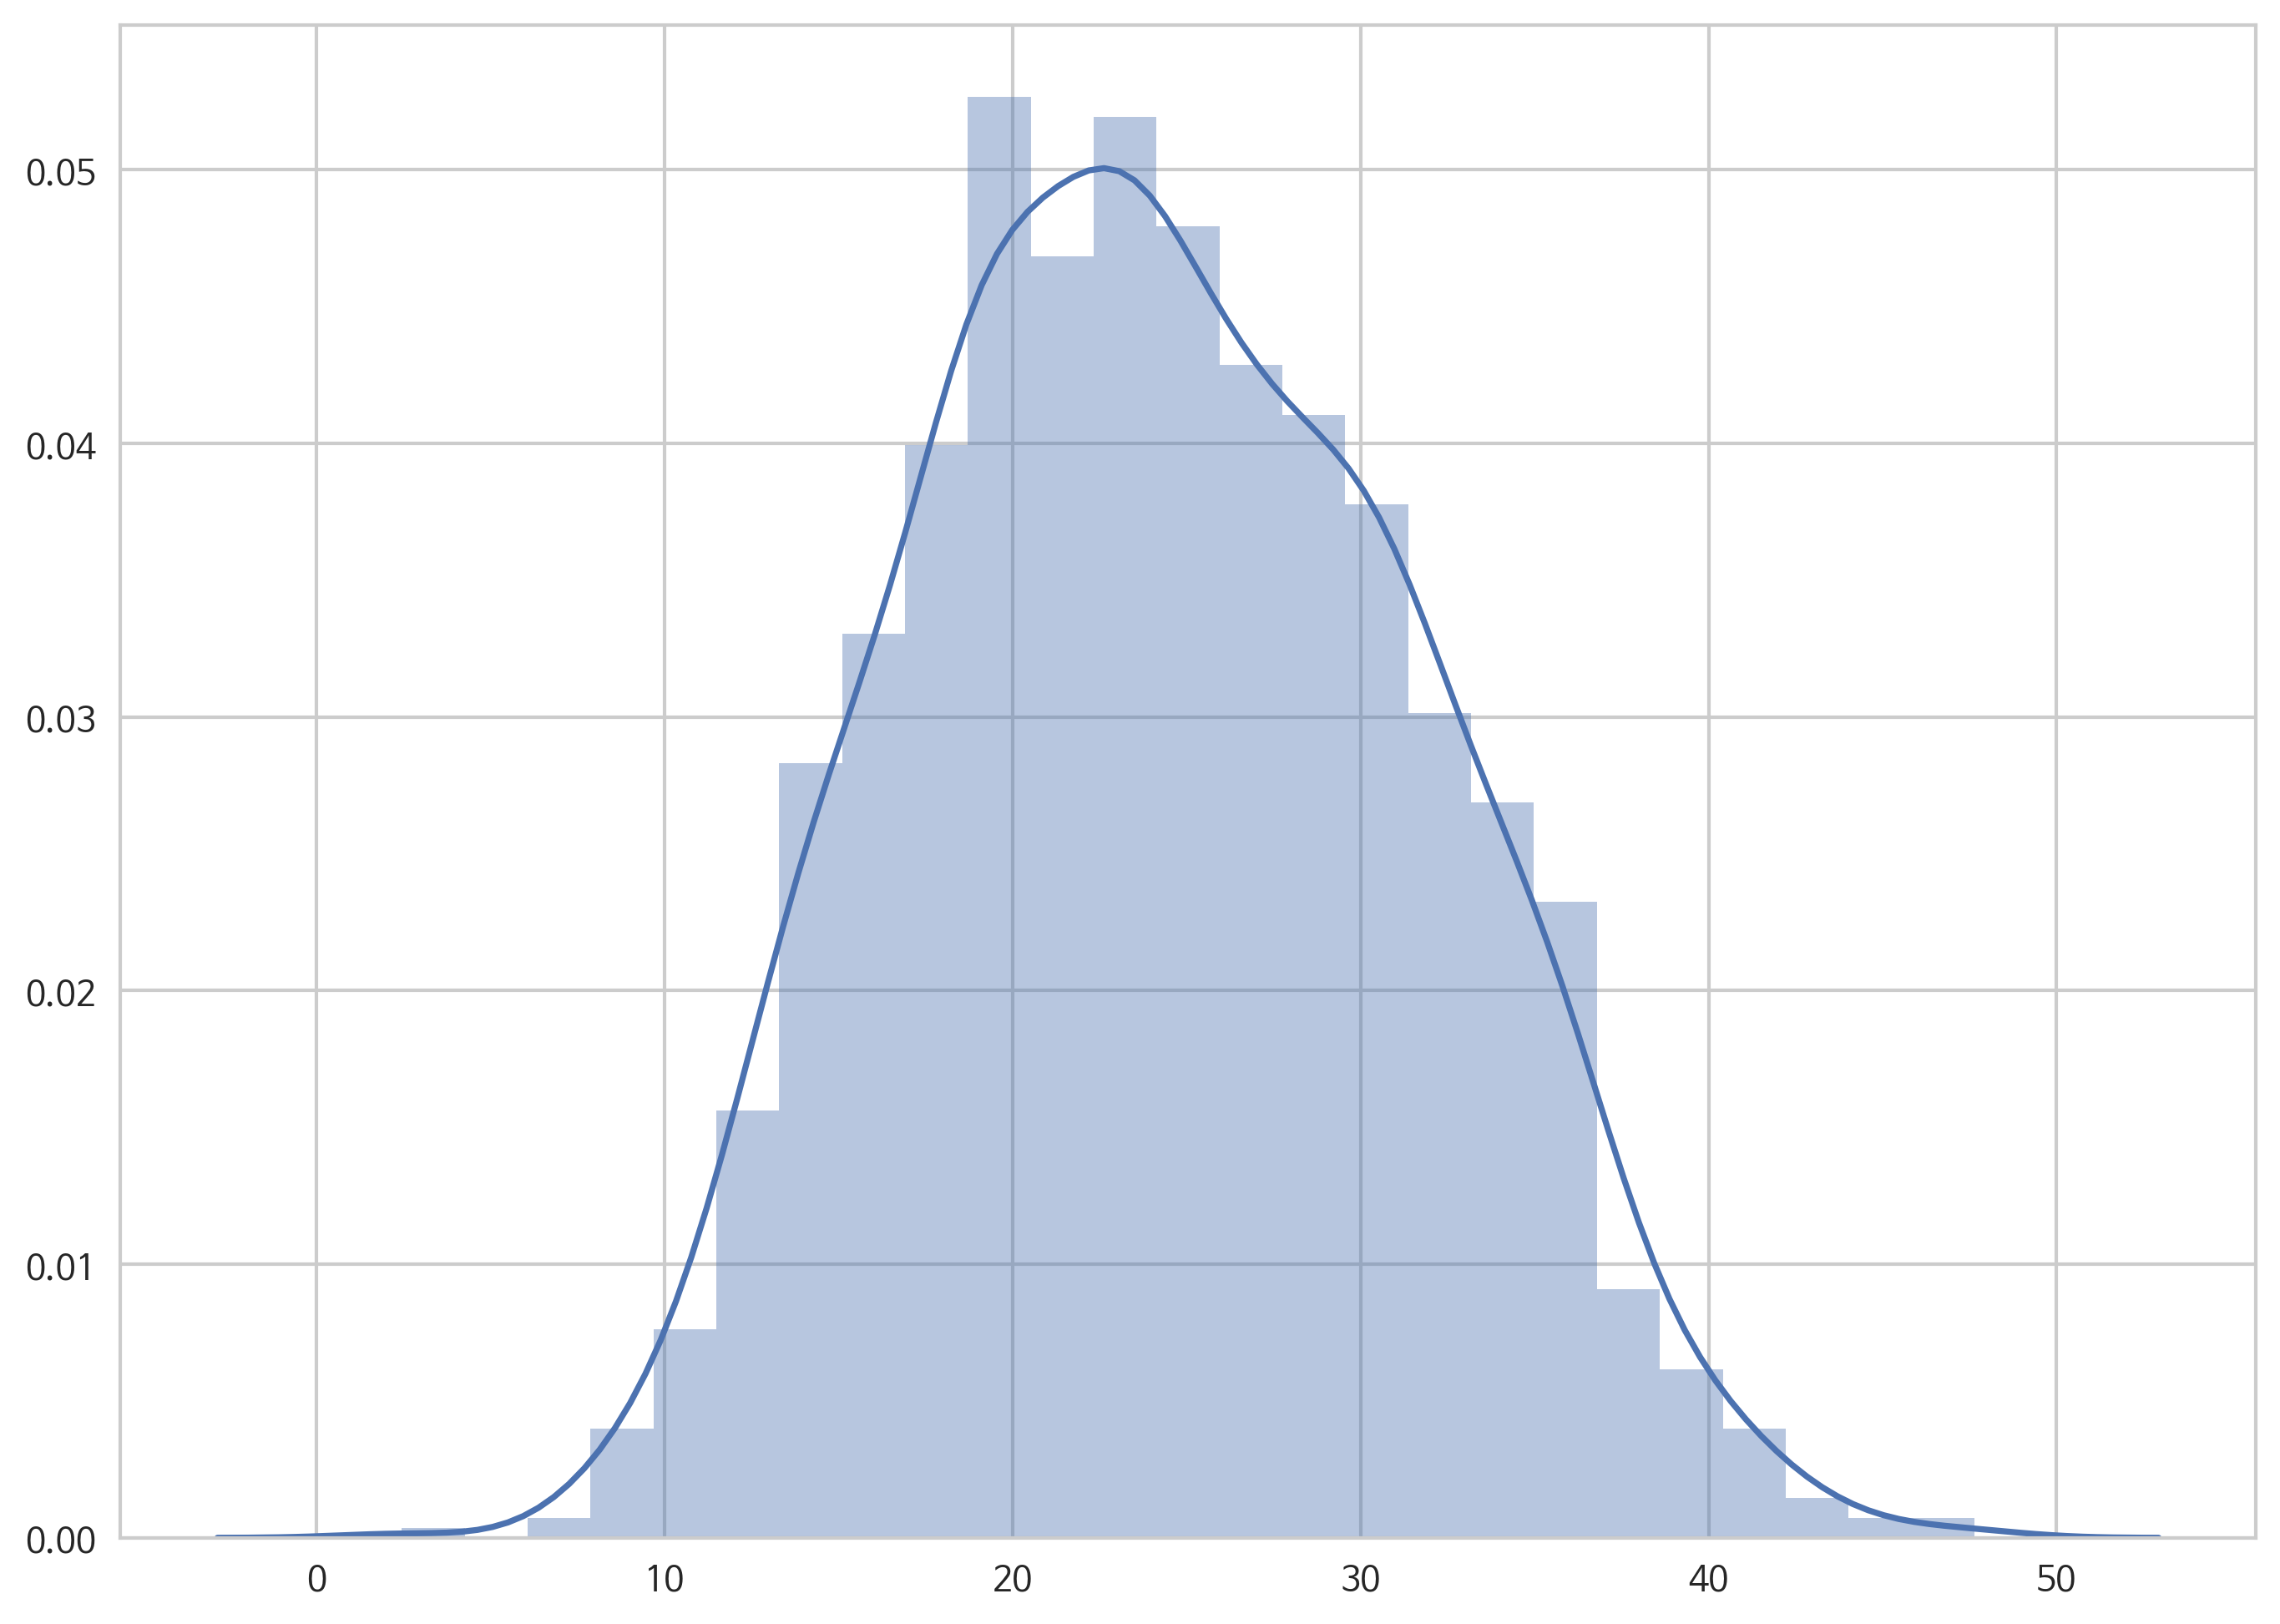

In [71]:
sns.distplot(privacy_comic_table.mean(axis=1))

In [72]:
def maxscale(x):
    return x / x.max()

In [73]:
privacy_comic_table = maxscale(privacy_comic_table)

In [74]:
purchasing_power = privacy_comic_table.mean(axis=1)

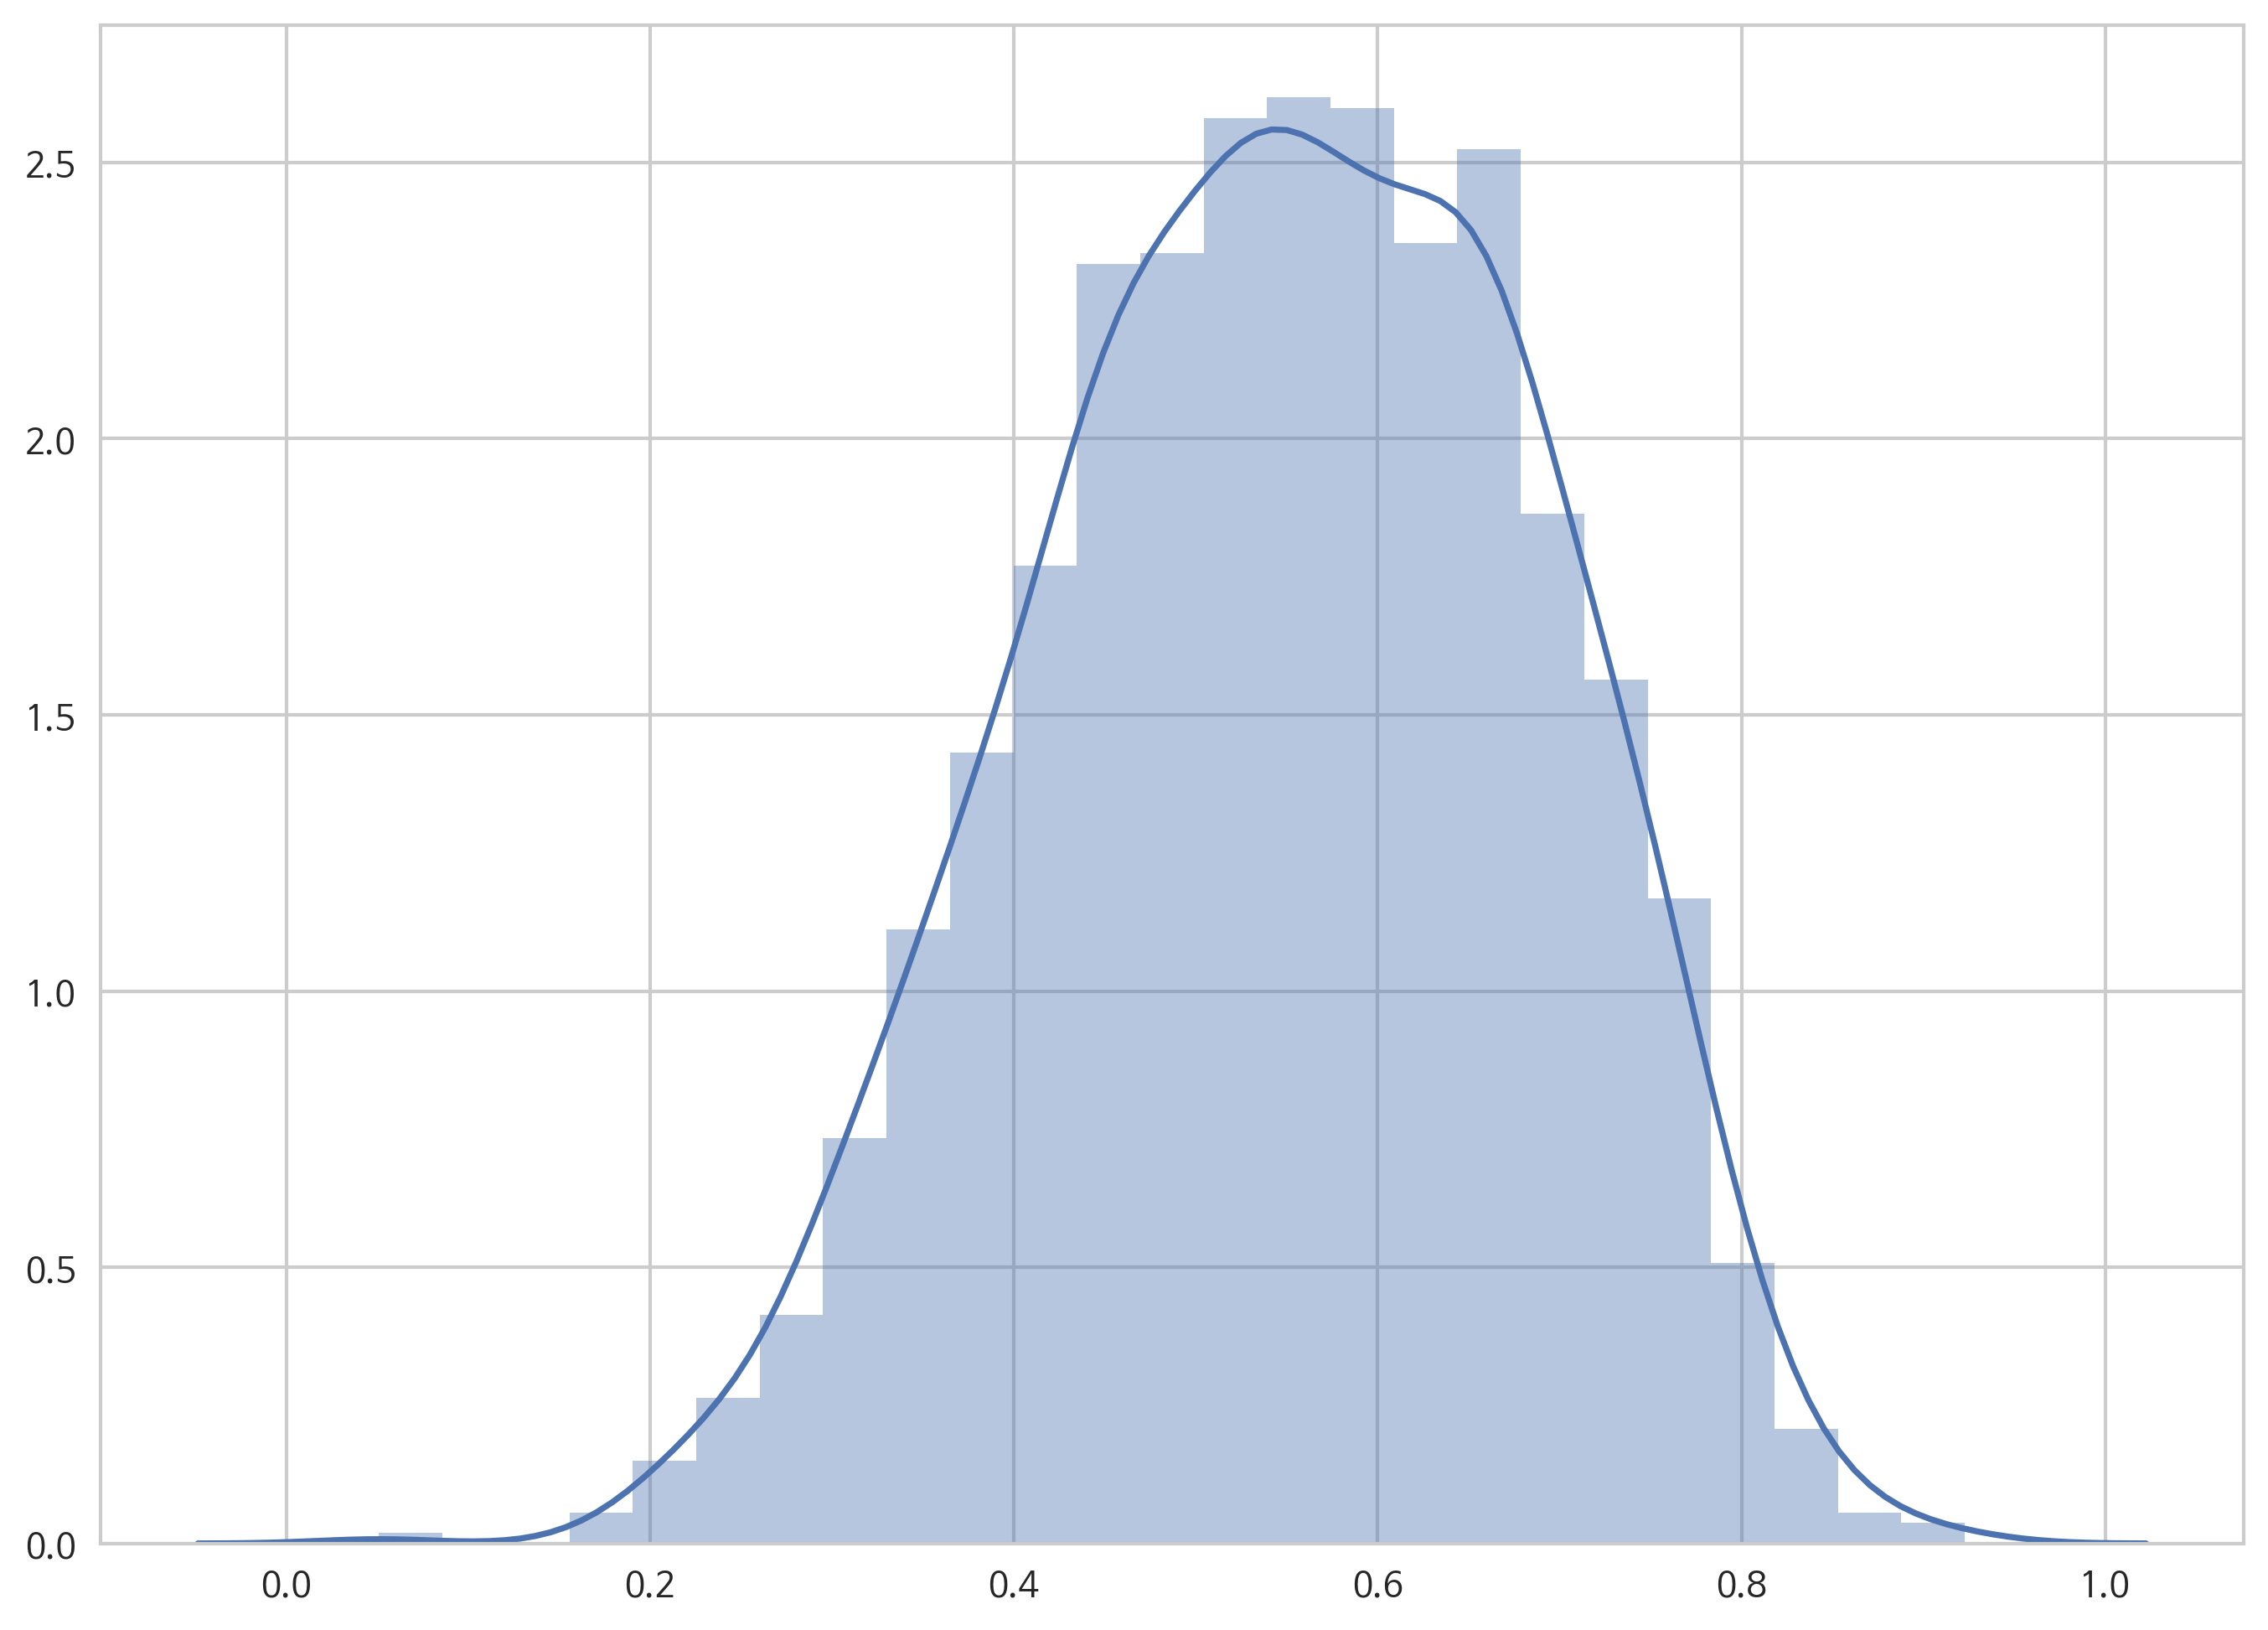

In [75]:
sns.distplot(purchasing_power)

In [42]:
bins = [-1, 0.2, 0.5, 0.6, 0.8, 1] # 향후 이것도 업데이트하는 방식으로 구현해볼만 할듯
labels = [0, 1, 2, 3, 4]
cats = pd.cut(purchasing_power, bins, labels=labels)

In [46]:
df = pd.merge(data, pd.DataFrame(cats, columns=['purchasing_power']).reset_index(), on='privacy_cat', how='outer', sort=False)

In [112]:
#df 칼럼 조정
c = df.columns.tolist()
lst = ['comic_hash_cat', 'privacy_cat', 'comic_hash', 'privacy_1'] + column2
for i in lst:
    c.remove(i)
c = c + lst
idx = c.index('purchasing_power')

In [114]:
df = df.loc[:,c]

In [115]:
df.tail()

,buyinhour,plat_A,plat_B,plat_C,plat_D,total_session,comic_tag1,coin_needed,end,schedule1,...,comic91,comic92,comic93,comic94,comic95,comic96,comic97,comic98,comic99,comic100
650960,1,1,0,0,0,23,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
650961,1,1,0,0,0,23,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
650962,1,1,0,0,0,36,0,3,0,0,...,0,0,0,0,0,37,0,0,0,0
650963,1,1,0,0,0,38,0,3,0,0,...,0,0,0,0,0,37,0,0,0,0
650964,1,1,0,0,0,40,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
y = df['buyinhour']
X = df.iloc[:,range(1, idx+1)]

In [124]:
y.value_counts()

0    429172
1    221793
Name: buyinhour, dtype: int64

# Navie Bayesian

In [117]:
from sklearn.naive_bayes import MultinomialNB

In [358]:
model_NB = MultinomialNB()

In [359]:
model_NB.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [360]:
yhat = model_NB.predict(train_X)

In [361]:
from sklearn.metrics import *

In [362]:
con_mat = confusion_matrix(y, yhat)
con_mat

array([[312376, 116796],
       [138736,  83057]])

In [363]:
print(classification_report(train_y, yhat, target_names=['notbuy', 'buy']))

             precision    recall  f1-score   support

     notbuy       0.69      0.73      0.71    429172
        buy       0.42      0.37      0.39    221793

avg / total       0.60      0.61      0.60    650965



In [364]:
fpr, tpr, thresholds = roc_curve(train_y, yhat)

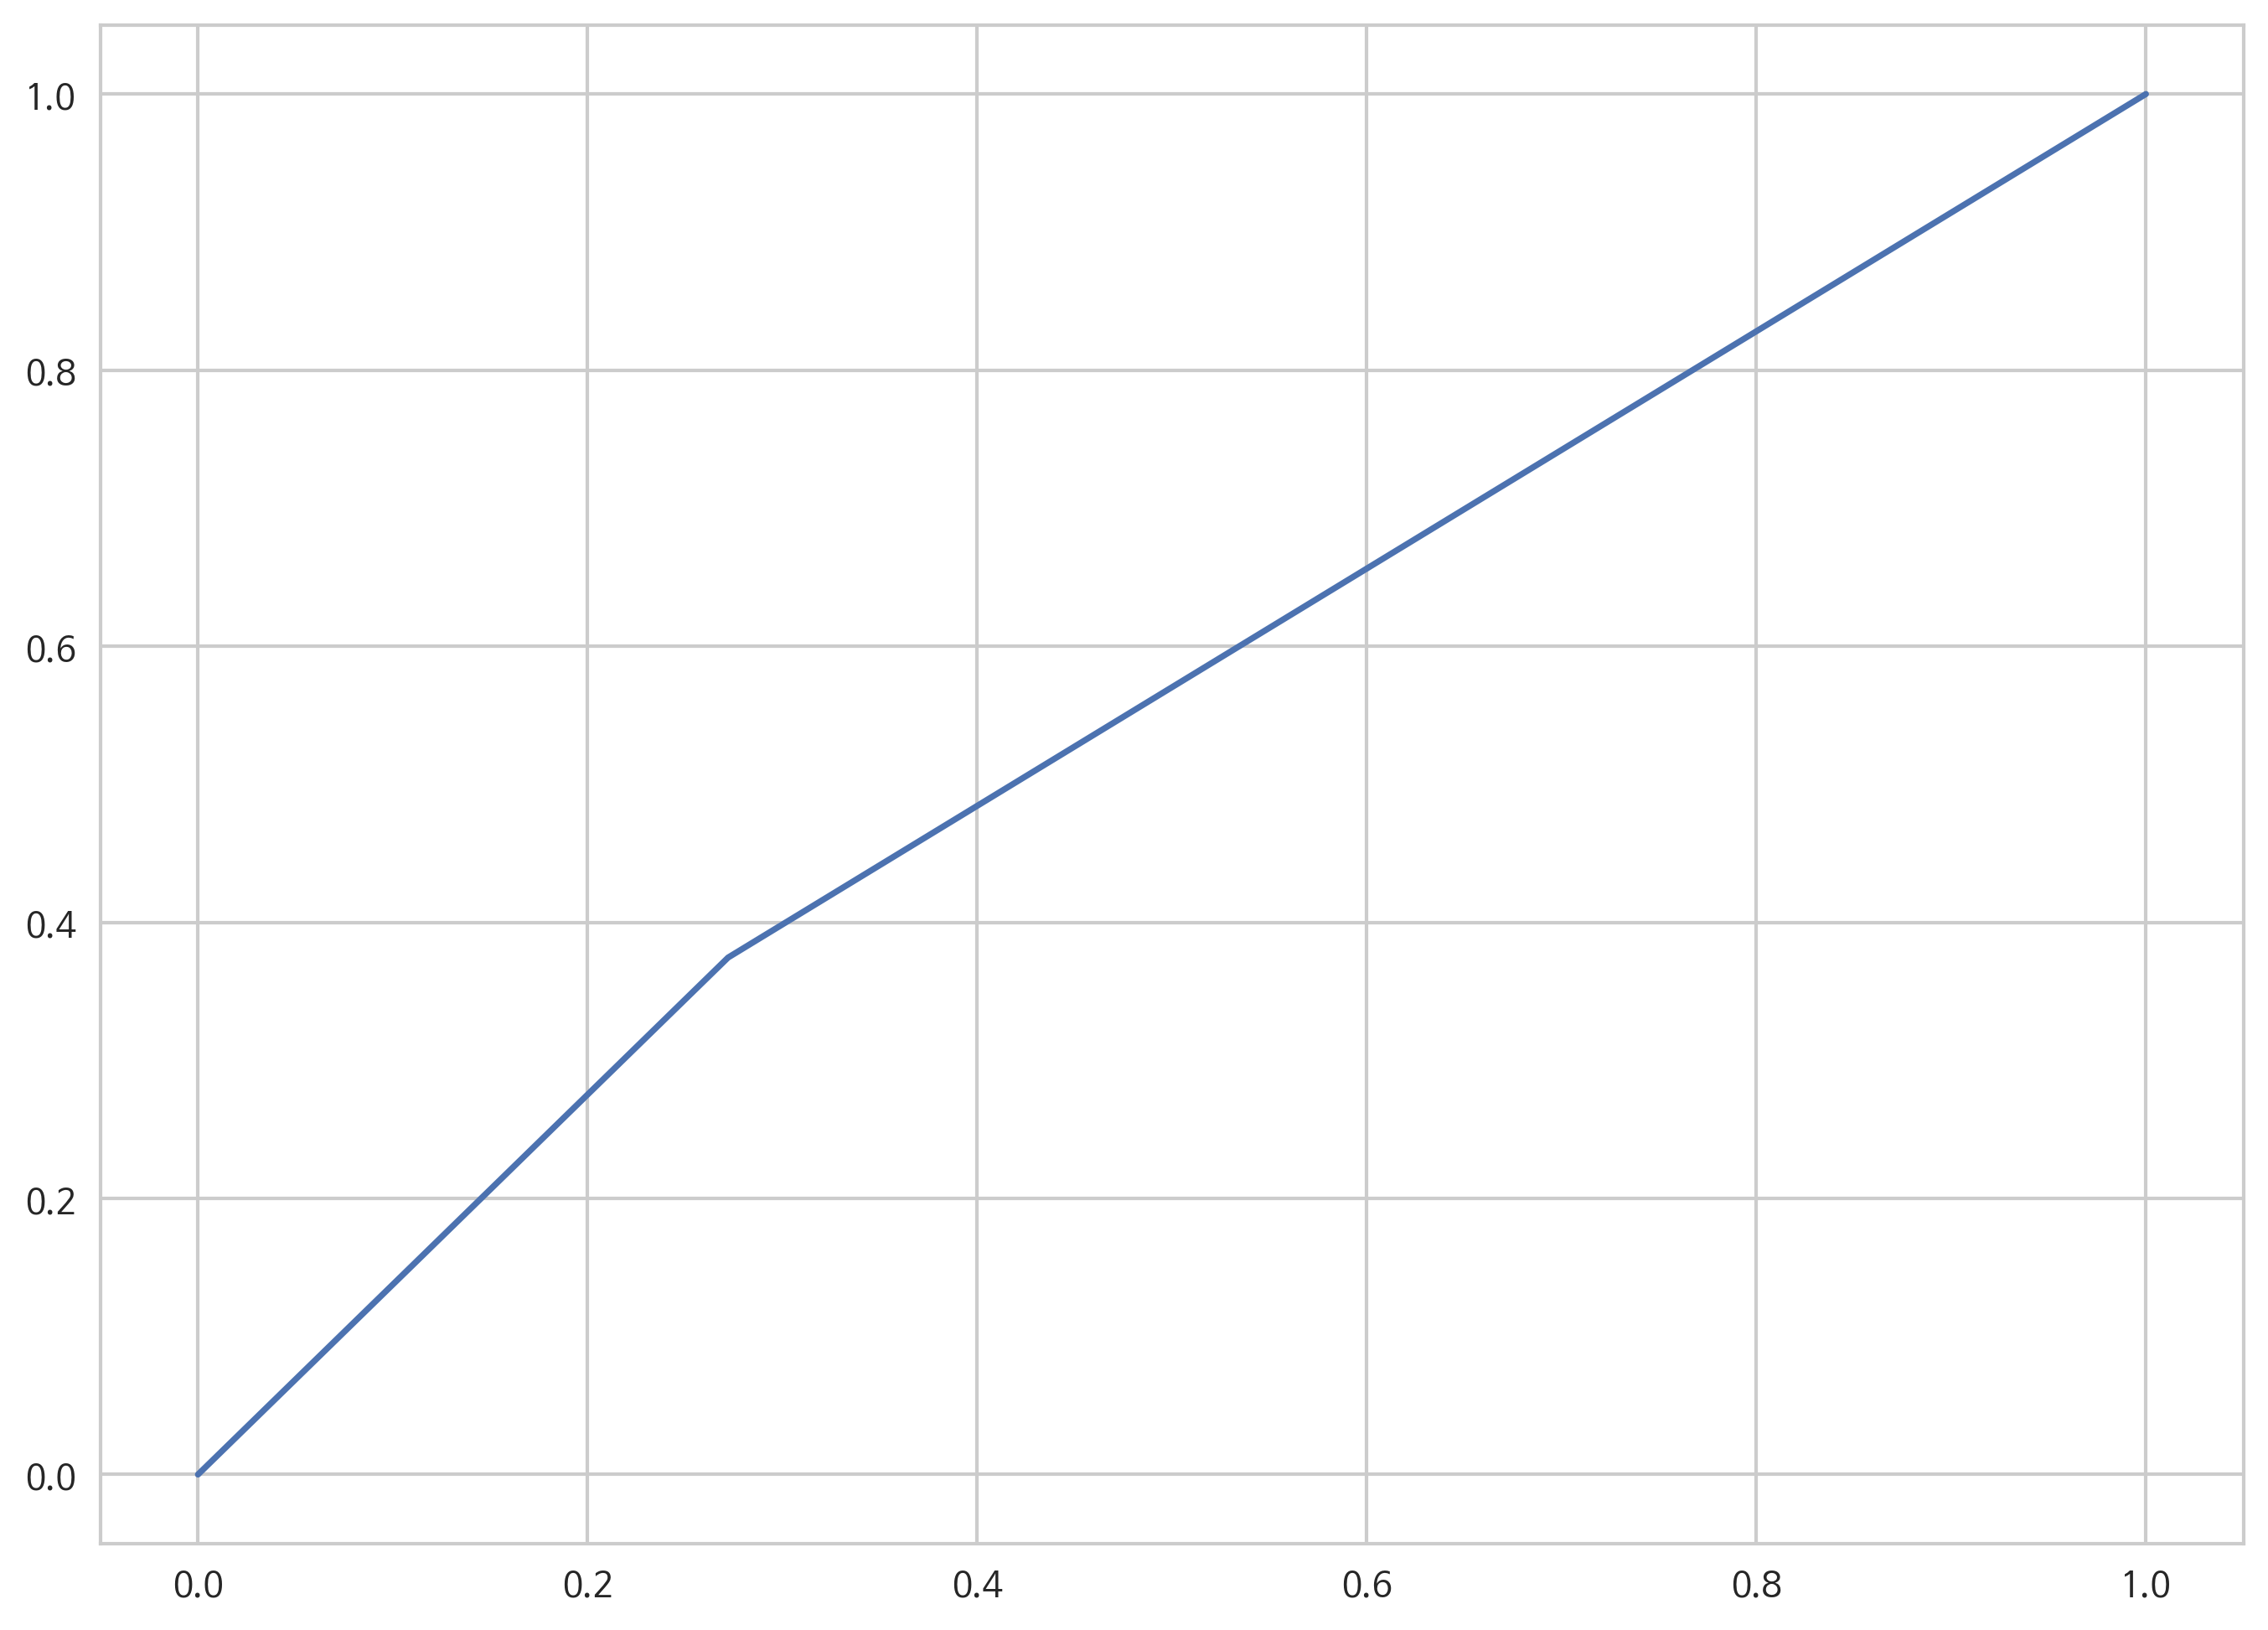

In [365]:
plt.plot(fpr, tpr)

# Decision Tree

In [181]:
from sklearn.tree import DecisionTreeClassifier

In [390]:
model_tree = DecisionTreeClassifier(criterion='gini').fit(train_X, train_y)

In [391]:
yhat = model_tree.predict(train_X)

In [392]:
con_mat = confusion_matrix(train_y, yhat)

In [393]:
con_mat

array([[408700,  20472],
       [ 38643, 183150]])

In [394]:
print(classification_report(train_y, yhat, target_names=['notbuy', 'buy']))

             precision    recall  f1-score   support

     notbuy       0.91      0.95      0.93    429172
        buy       0.90      0.83      0.86    221793

avg / total       0.91      0.91      0.91    650965



In [395]:
accuracy_score(train_y, yhat)

0.90918866605731496

In [396]:
fpr, tpr, thresholds = roc_curve(train_y, yhat)

In [397]:
fpr, tpr

(array([ 0.        ,  0.04770115,  1.        ]),
 array([ 0.        ,  0.82576997,  1.        ]))

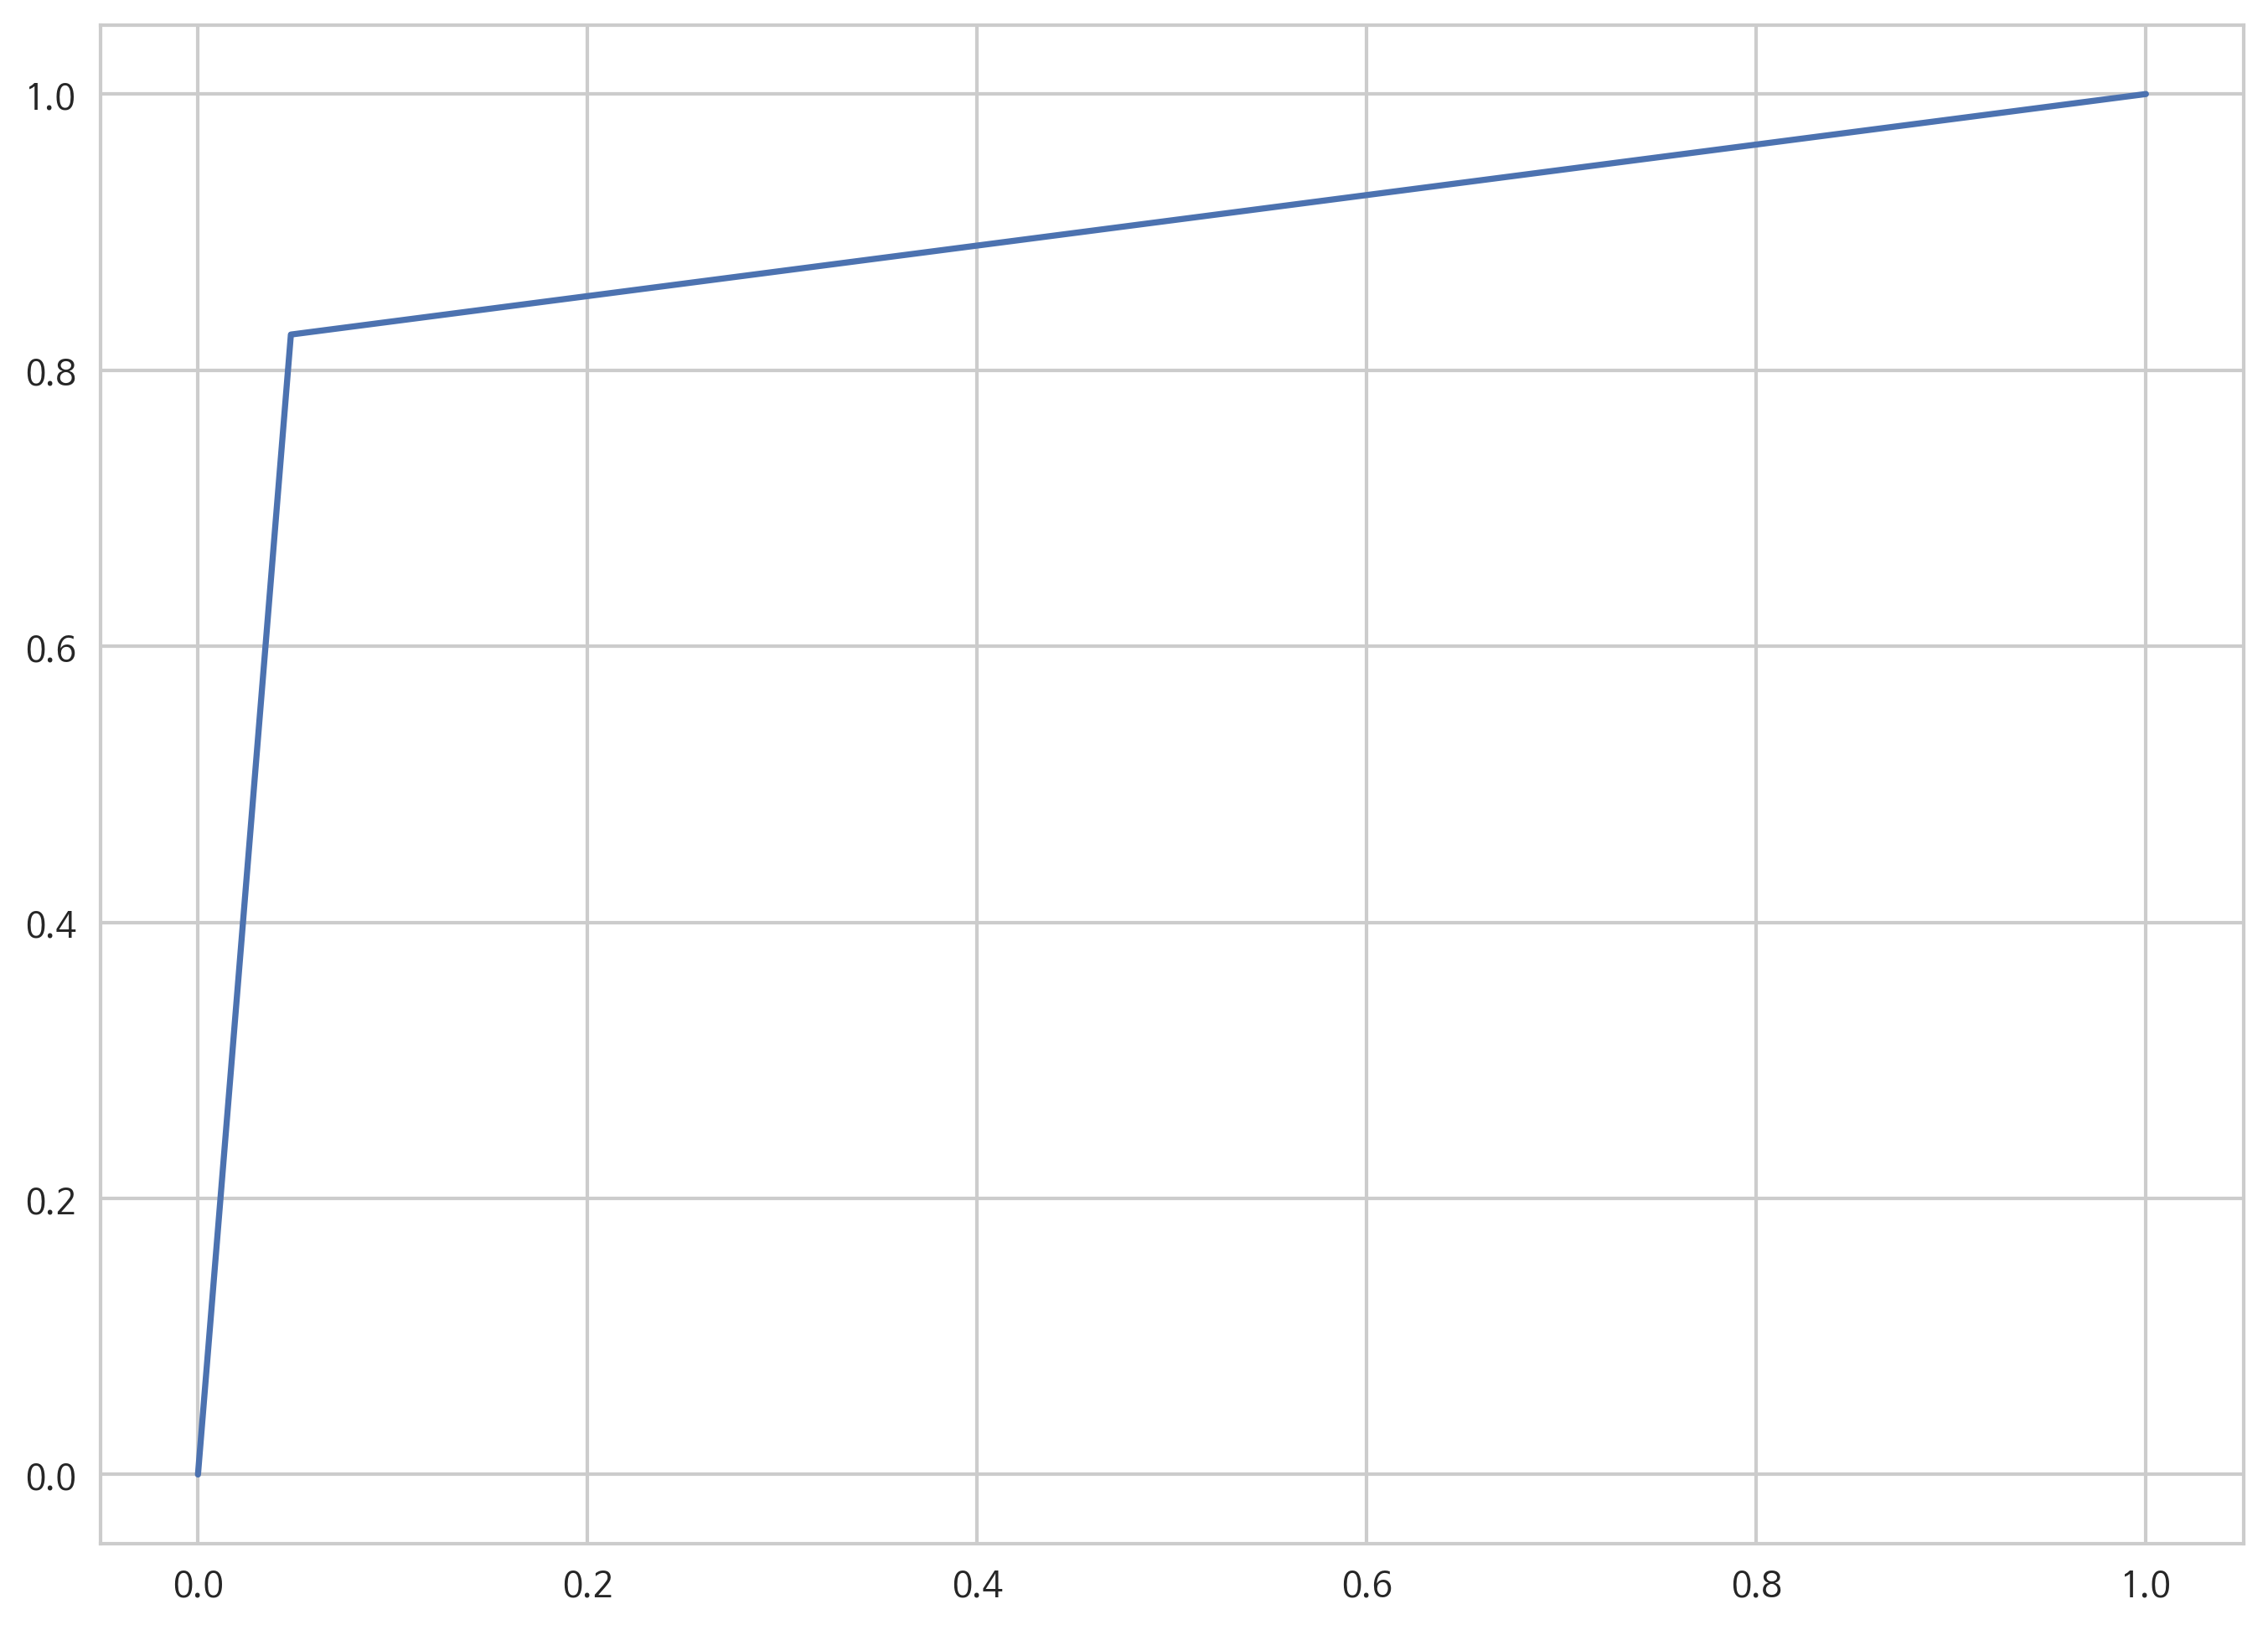

In [398]:
plt.plot(fpr, tpr)

In [256]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [399]:
cross_val_score(model_tree, train_X, train_y, scoring='accuracy')

array([ 0.66318108,  0.66679724,  0.67110624])

In [207]:
from io import StringIO
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(classifier):
    dot_buf = StringIO() 
    export_graphviz(classifier, out_file=dot_buf, feature_names=train_X.columns)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [250]:
export_graphviz(model_tree, out_file='tree.dot', feature_names=train_X.columns)

In [352]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [383]:
model_forest = ExtraTreesClassifier()

In [384]:
model_forest.fit(train_X, train_y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [385]:
yhat = model_forest.predict(train_X)
con_mat = confusion_matrix(train_y, yhat)
con_mat

array([[408700,  20472],
       [ 38643, 183150]])

In [386]:
print(classification_report(train_y, yhat, target_names=['notbuy', 'buy']))

             precision    recall  f1-score   support

     notbuy       0.91      0.95      0.93    429172
        buy       0.90      0.83      0.86    221793

avg / total       0.91      0.91      0.91    650965



In [387]:
accuracy_score(train_y, yhat)

0.90918866605731496

In [388]:
fpr, tpr, thresholds = roc_curve(train_y, yhat)

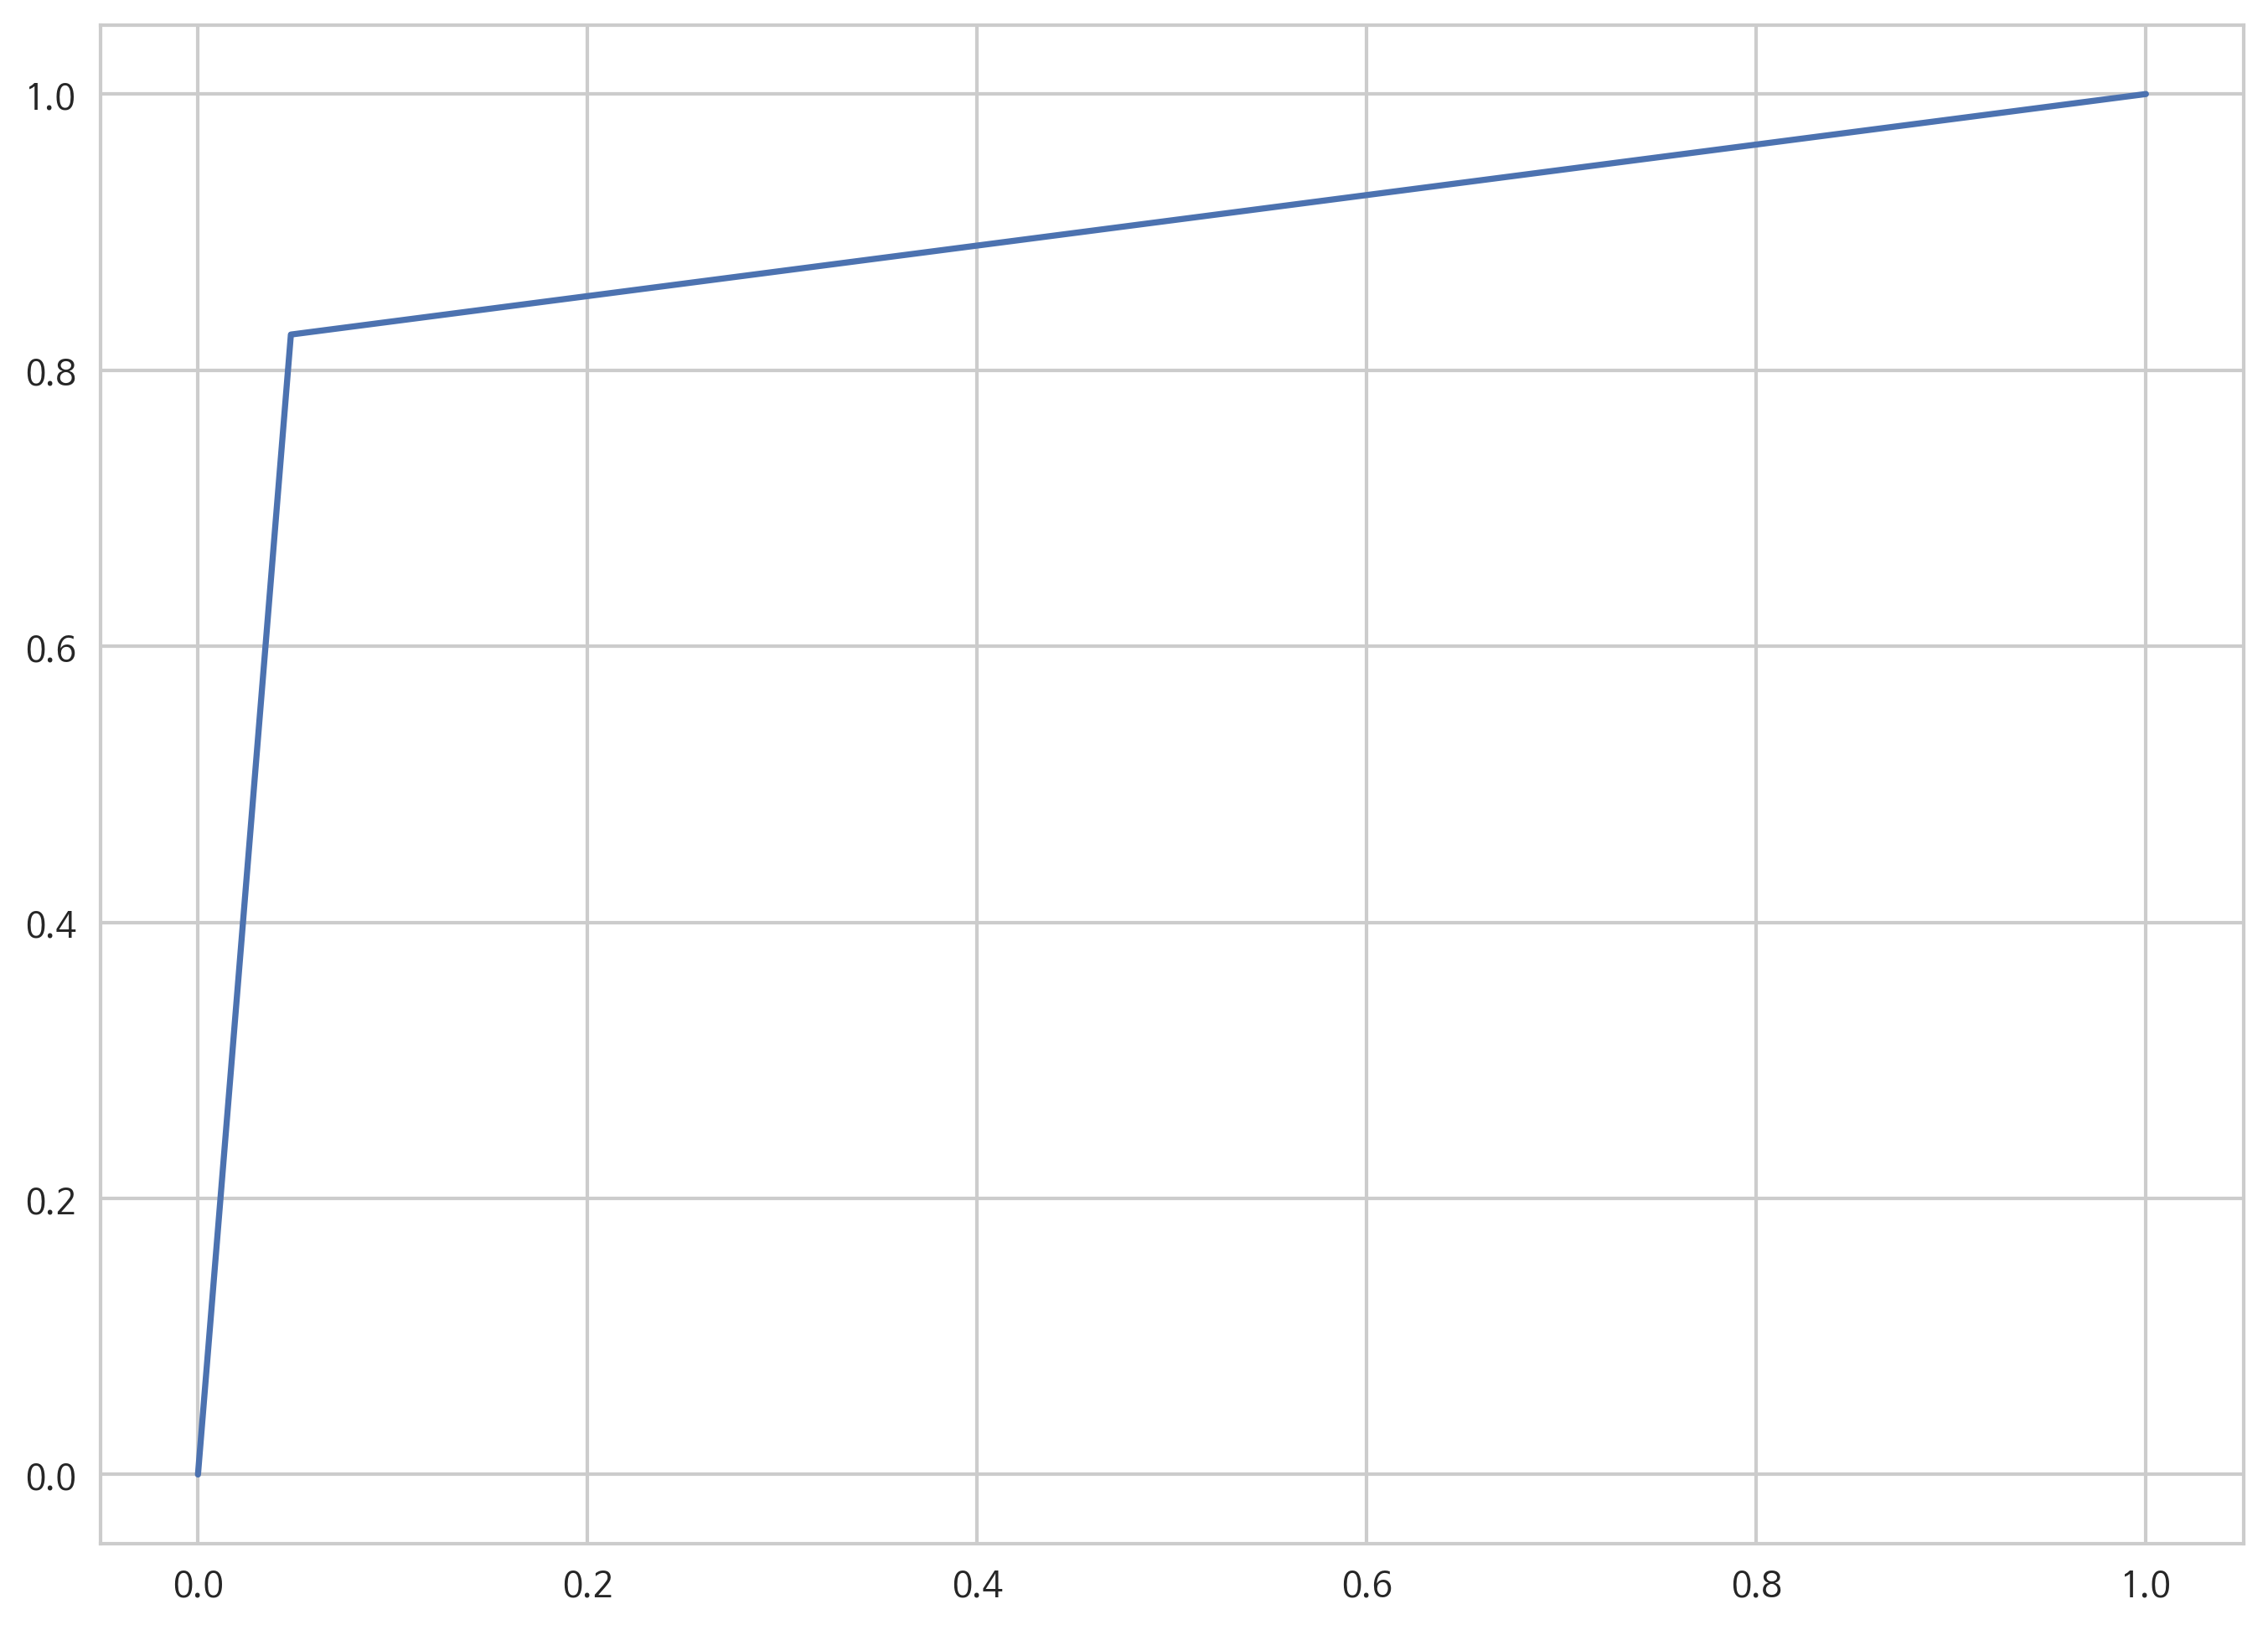

In [389]:
plt.plot(fpr, tpr)

In [400]:
cross_val_score(model_forest, train_X, train_y, scoring='accuracy')

array([ 0.66870671,  0.6709772 ,  0.67759968])

In [301]:
importances = model_forest.feature_importances_

In [348]:
std = np.std([tree.feature_importances_ for tree in model_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [349]:
indices

array([ 4,  5, 46, 38, 39,  7, 15,  3, 36,  1, 37, 19,  0,  6, 20, 22, 32,
       25, 12, 10, 23, 33, 21,  8,  2, 13, 14, 18, 26, 11,  9, 31, 43, 42,
       34, 44, 45, 28, 29, 30, 27, 24, 35, 16, 17, 41, 40])

In [350]:
column_list = train_X.columns.tolist()

In [351]:
gage = 0
for f in range(train_X.shape[1]):
    if gage <= 0.8:
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f], column_list[indices[f]], importances[indices[f]]))
        gage += importances[indices[f]]

1. feature 4: total_session (0.627667)
2. feature 5: comic_tag1 (0.045901)
3. feature 46: purchasing_power (0.039046)
4. feature 38: comic_start (0.024669)
5. feature 39: total_episode (0.022220)
6. feature 7: end (0.019542)
7. feature 15: schedule8 (0.018729)
8. feature 3: plat_D (0.018653)


그냥 똑같음 랜덤포레스트나 익스포레스트나

In [402]:
y_tree = model_tree.predict(test_X)
y_forest = model_forest.predict(test_X)

In [412]:
y_tree.sum() / len(y_tree)

0.33903534143183761

In [413]:
y_forest.sum() / len(y_forest)

0.33275486874363003

In [414]:
train_y.sum() / len(train_y)

0.34071417050071817

In [416]:
train_data

,buyinhour,plat_A,plat_B,plat_C,plat_D,total_session,comic_tag1,coin_needed,end,schedule1,...,comic91,comic92,comic93,comic94,comic95,comic96,comic97,comic98,comic99,comic100
0,0,0,0,0,1,1,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,104,1,3,1,0,...,0,0,0,4,0,0,0,0,0,1
5,0,0,0,0,1,166,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,174,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,187,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,2,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,2,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
